Because the work of the miners is considered extremely unhealthy, the company, by state regulation, has to give 60 days of psychological leave per year. The goal is to understand what causes employees to take days for psychological problems. Consulting with psychologists, they indicated that the problem could be caused by long trips and excessive idle time, they proposed that an indicator could be mental maturity, reflected in the age of the miners. In addition one of the psychologists proposed to measure how much miners read.

The company collected data from the past years from some of its best employees. They were shown a sheet of a standardized length and each miner was asked to estimate how many sheets he read per day. A dataset was put together with the number of days that licenses were requested in the last 3 years, their current age and the number of sheets they read per day.

With the data collected R5 try to predict the number of days of psychological leave that an employee would take in the next year.



In [37]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot  as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from IPython.display import Image

import val_curves_helper as vc_helper
import lr_assumptions as lr


In [14]:
df = pd.read_csv('R5.csv')

In [5]:
df.describe()

,pages_per_day_samples,age_samples,days_in_yrs_samples
count,150.000000,150.000000,150.000000
mean,52.200000,36.540000,66.280000
std,39.393387,7.485673,49.157755
min,0.000000,21.000000,0.000000
25%,27.000000,31.000000,29.250000
50%,43.000000,36.000000,52.000000
75%,62.000000,41.000000,87.000000
max,250.000000,60.000000,180.000000


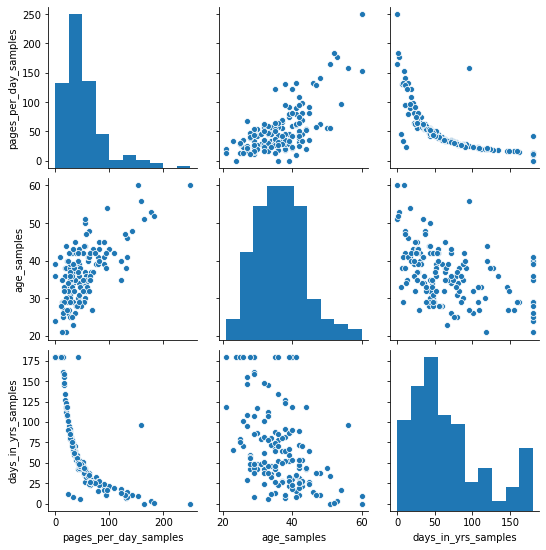


- observamos outliers


In [6]:
sns.pairplot(df)
plt.show()
print()
print("- we observe outliers")

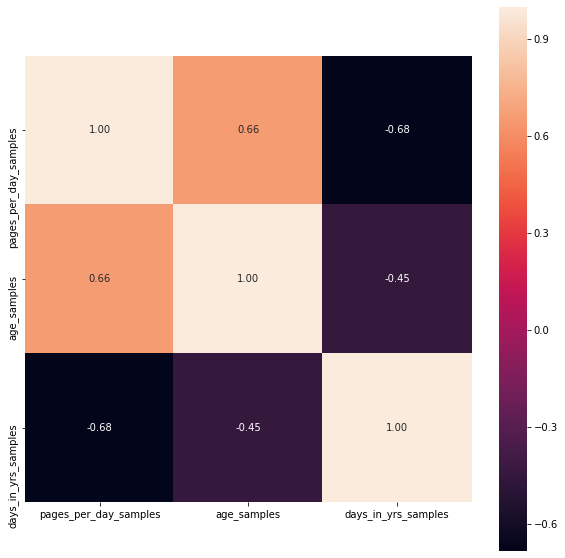

In [166]:
# correlation matrix as heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), square=True, annot=True, fmt='.2f')
plt.show()

In [140]:
def get_column(A, j): 
    return A.iloc[:,j]

def boxplot_list(df):
    
    df = df.copy().dropna()

    _, num_columns = df.shape
    fig, ax = plt.subplots(1, num_columns, figsize = (4 * num_columns, 4)) 
    red_square = dict(markerfacecolor='r', marker='s')
    columns = df.columns.values
    
    for i in range(num_columns):        
        i_column = get_column(df, i)

        ax[i].boxplot(x=i_column, vert=False, flierprops=red_square)
        ax[i].xaxis.set_visible(True) 
        ax[i].yaxis.set_visible(True)
        ax[i].set_xlabel(columns[i], fontsize=14)
        
    plt.show()

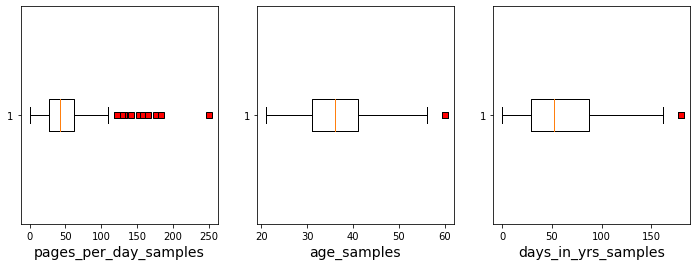

In [218]:
boxplot_list(df)

## Removing outliers

In [27]:
# ATENCION !!!
# BUSCAR OUTLIERS USANDO Z SCORE SOLO SIRVE SI LA DISTRIB ES NORMAL !!!
# ENTONCES ESTO QUE HICE ESTA MAL, DEBERIA HACER ALGO COMO:
#
# q = df['pages_per_day_samples'].quantile(0.95)
# df_ = df[df['pages_per_day_samples'] < q]
#
# CON ESTO REMUEVO EL 5% DE ARRIBA DE LA DISTRIBUCION
#

# encuentro outliers con una desviacion estandar normal > 3
threshold = 3
z = np.abs(stats.zscore(df.dropna()))
outliers = np.where(z > threshold)
#outliers[0] corresponde al nro de row
#outliers[1] corresponde al nro de col
print(outliers[0])

#count = 0
#for i in outliers[0]:
#    print(df[df.index == i])
#    column_index = outliers[1][count]
#    print("columna:", df.columns[column_index])
#    count = count + 1
#    print("===============")

#removing duplicated indexes
outliers_list = outliers[0]
outliers_list = list(dict.fromkeys(outliers_list))

for outlier_index in outliers_list:
    df.drop(outlier_index, inplace=True)
    df.reset_index(drop=True, inplace=True)

[]


In [ ]:
#identifying outliers by hand & #removing outliers by hand
outliers = df[(df['days_in_yrs_samples'] > 175) & (df['pages_per_day_samples'] < 50)].index.tolist()
df.drop(outliers, inplace=True)

outliers = df[(df['days_in_yrs_samples'] < 25) & (df['pages_per_day_samples'] < 50)].index.tolist()
df.drop(outliers, inplace=True)

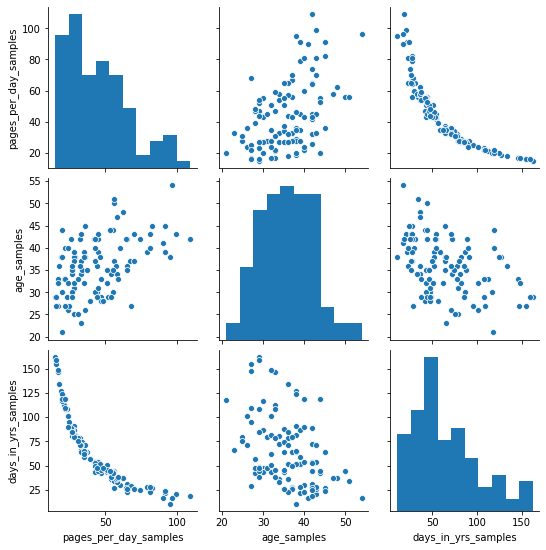

In [36]:
sns.pairplot(df)
plt.show()

- comparando con el pairplot inicial se puede observar una limpieza de outliers

## feature engineering

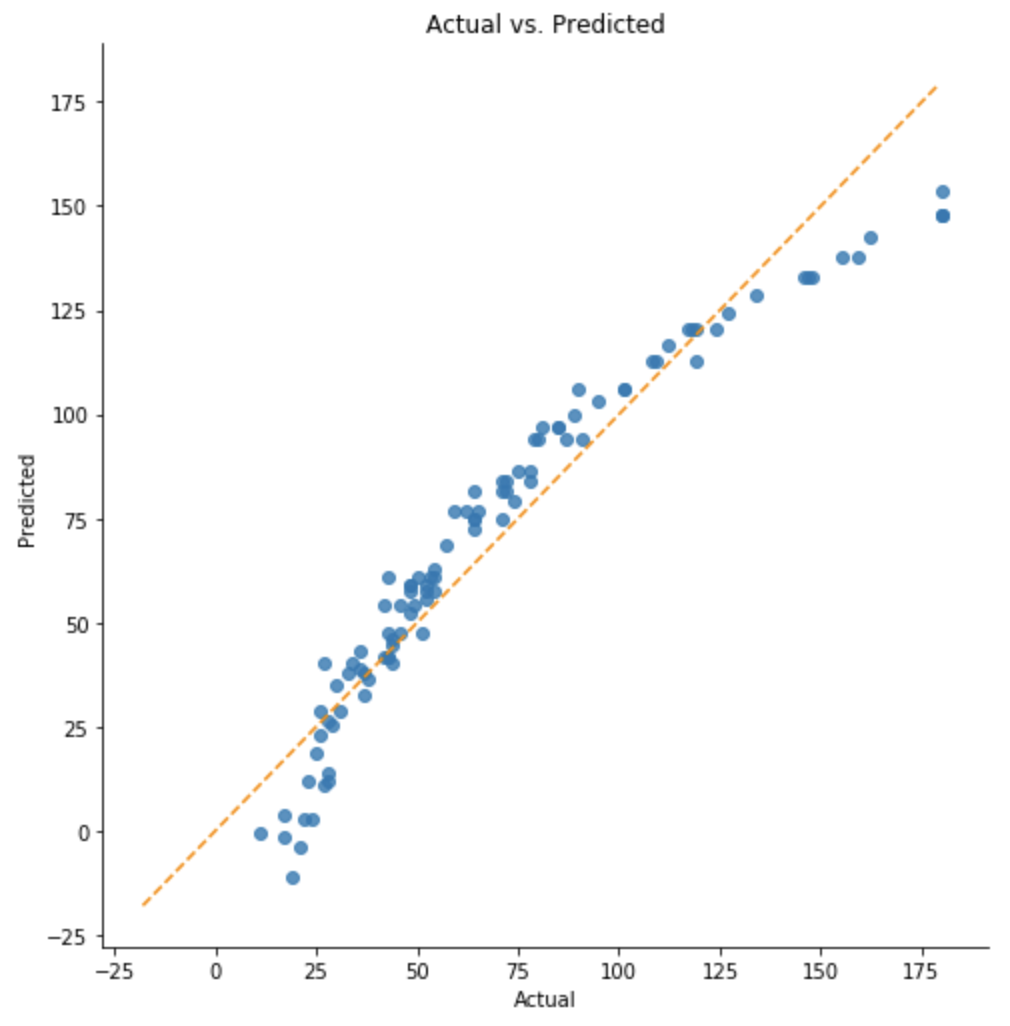

In [952]:
# We tried to create the feature df ['pages_per_day_samples_x_age_samples'] = df.pages_per_day_samples * df.age_samples
# with the intention of finding out if there is synergy between them, obtain a better correlation coefficient and
# to be useful when calculating the linear regression, but the resulting feature did not have so much more correlation coefficient
# than the features that formed it. It also produced a high degree of multicollinearity in the dataset and did not
# I contribute to the search for better metrics when training the model.

# We test with the transformation df ['log_pages_per_day_samples'] = np.log (df.pages_per_day_samples)
# because days_in_yrs_samples seems to have a logarithmic relationship, but it doesn't quite fit.
# In fact if we train the linear regression only with log_pages_per_day_samples and check the
# 1st linear_assumption we can notice that the residuals are not symmetrically distributed (img is attached)
#

Image("picture-01.png", width=300)

In [38]:
# We find out that the relationship between 'pages_per_day_samples' and 
# 'days_in_yrs_samples' have the form y = 1 / Ax + B

df['pages_per_day_samples_transf'] = 1 / (df.pages_per_day_samples)
df = df[(df != 0).all(1)] #removing -inf values ( X == 0 )

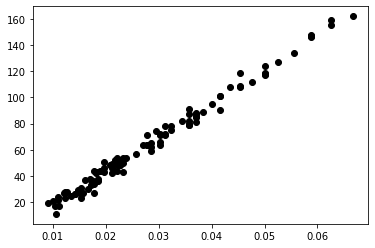

In [40]:
plt.scatter(df.pages_per_day_samples_transf, df.days_in_yrs_samples,  color='black')
plt.show()

- We note that we were able to transform pages_per_day_samples into a linear function

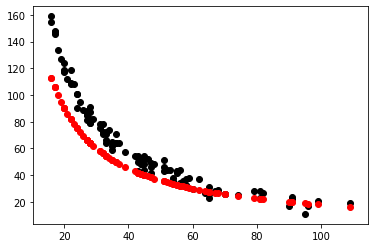


#Ahora sabemos que la funcion tiene la forma de y = 1/Ax + B
#funcion_days_in_yrs_samples(pages_per_day_samples) = 1800/pages_per_day_samples"
#entonces si t = 1 / pages_per_day_samples me queda que:
#funcion_days_in_yrs_samples(t) = 1800 * t



In [1059]:
fc = 1800/(df.pages_per_day_samples) + 0

plt.scatter(df.pages_per_day_samples, df.days_in_yrs_samples,  color='black')
plt.scatter(df.pages_per_day_samples, fc, color='red')
plt.show()

print("""
#Now we know that the function has the form of y = 1 / Ax + B
#funcion_days_in_yrs_samples (pages_per_day_samples) = 1800 / pages_per_day_samples "
#then if t = 1 / pages_per_day_samples we have that:
#funcion_days_in_yrs_samples (t) = 1800 * t""")

## Fit model 

In [41]:
def print_model_statistics(regr, y_test, y_pred):

    # The coefficients
    print('Coefficients: ', regr.coef_)

    # The intercept_ 
    print('Intercept (Y axis when X = 0): ', regr.intercept_)

    # The mean squared error
    print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))

    # The coefficient of determination: 1 is perfect prediction
    r2 = r2_score(y_test, y_pred)
    print('Coefficient of determination: %.2f' % r2)
    
    # Adjusted r2
    n = X_test.shape[0]
    p = X_test.shape[1]
    adjusted_r2 = 1 - (1-r2) * (n-1)/(n-p-1)
    print('Adjusted r2: %.2f' % adjusted_r2)
    
    #explained_variance_score
    print('explained_variance_score: %.2f' % explained_variance_score(y_test, y_pred))

## LinearRegression 

In [1071]:
X = df[[
#    'pages_per_day_samples',
#   'age_samples',
    'pages_per_day_samples_transf'
       ]]
y = df.days_in_yrs_samples

seed = 42
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

regr = LinearRegression().fit(X_train, y_train)
y_pred = regr.predict(X_test)

print_model_statistics(regr, y_test, y_pred)

print("")
print("- It can be seen that adding the age_samples does not improve the metrics")

Coefficients:  [2602.15480723]
Intercept (Y axis when X = 0):  -8.938021299405378
Mean squared error: 11.78
Coefficient of determination: 0.99
Adjusted r2: 0.98
explained_variance_score: 0.99

- Se puede observer que agregar la age_samples no mejora las metricas


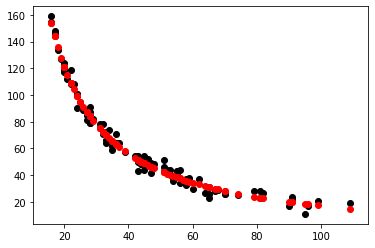

In [1075]:
fc = 2602.15480723/(df.pages_per_day_samples) + -8.938021299405378
plt.scatter(df.pages_per_day_samples, df.days_in_yrs_samples,  color='black')
plt.scatter(df.pages_per_day_samples, fc, color='red')
plt.show()

In [43]:
# I train linear model with 2 features and graph the plane resulting from the linear reg. I'm just playing,
# we already know that age_samples contributes little and nothing to the regression.
#

X = df[['age_samples',
        'pages_per_day_samples_transf'
       ]]
y = df.days_in_yrs_samples

seed = 42
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

regr = LinearRegression().fit(X_train, y_train)
y_pred = regr.predict(X_test)

print_model_statistics(regr, y_test, y_pred)

Coefficients:  [9.37157663e-02 2.62033411e+03]
Intercept (Y axis when X = 0):  -12.866234719742891
Mean squared error: 5.13
Coefficient of determination: 0.99
Adjusted r2: 0.99
explained_variance_score: 0.99


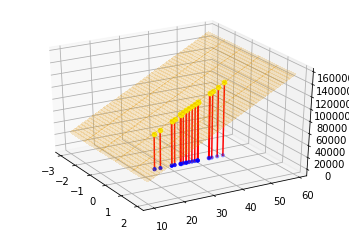

In [1029]:
from mpl_toolkits.mplot3d import Axes3D
import math

ax = plt.figure().gca(projection='3d')
ax.scatter(X_test['pages_per_day_samples_transf'], X_test['age_samples'], y_test.values, color="blue", s=10)
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')

count = 0
for i in range(len(X_test)):
    xs = X_test['pages_per_day_samples_transf'].values[count]
    ys = X_test['age_samples'].values[count]
    zs = y_test.to_numpy()[count]#lo convierto a array asi no lo accede por indice !!
    pred_z = regr.predict([[xs, ys]])
    
    ax.plot([xs, xs], [ys, ys], [zs, pred_z], color="red")
    ax.scatter(xs, ys, pred_z, marker='o', color="yellow")
    
    count = count + 1

#plano
xx, yy = np.meshgrid(range(-3,3), range(10,60))
model_z_vals = np.zeros(xx.shape)
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        model_z_vals[i, j] = regr.predict([[xx[i][j], yy[i][j]]])

ax.plot_surface(xx, yy, model_z_vals, alpha=0.2, color="orange", antialiased=False)

ax.view_init(30, -30)
plt.draw()
plt.pause(.001)

### Performance & sensitivity analysis

/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less tha

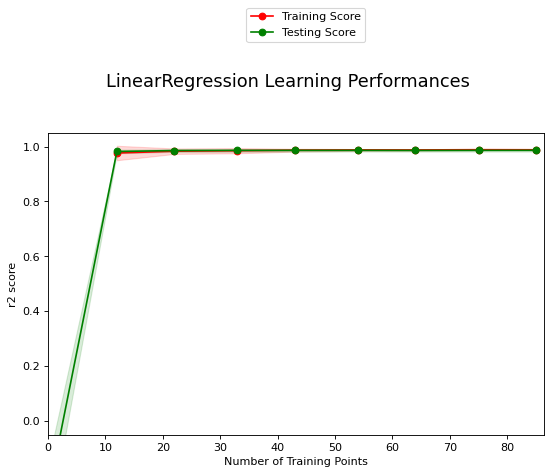

In [44]:
vc_helper.plot_learning_performance(regr, X, y)

- No trace of overfitting or underfitting is observed
- Few points are needed for the model to adjust to the behavior of the dataset

In [46]:
data_to_trial = (40, 0.041667)
vc_helper.predict_trials(X, y, regr, data_to_trial)

Trial 1: 100.45
Trial 2: 100.09
Trial 3: 100.31
Trial 4: 100.38
Trial 5: 101.35
Trial 6: 99.68
Trial 7: 100.89
Trial 8: 99.83
Trial 9: 99.71
Trial 10: 99.69

Range in values: 1.68


- the range observed between Trials is not significant, therefore the uniformity in the distribution of data that we can observe in the linear graph is re-validated

## MLPRegressor 

In [73]:
from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing

X = df[['pages_per_day_samples_transf',
        'age_samples'
       ]]
y = df.days_in_yrs_samples

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model_nn = MLPRegressor(max_iter=5000, activation='logistic', learning_rate='adaptive')

model_nn.fit(X_train,y_train)

/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='logistic', learning_rate='adaptive', max_iter=5000)

In [79]:
y_pred = model_nn.predict(X_test)

In [80]:
print(mean_squared_error(y_test, y_pred))
print(explained_variance_score(y_test, y_pred))

21.27217336522745
0.9775452039880268


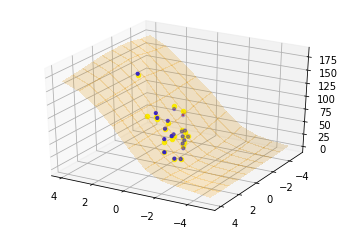

In [1045]:
from mpl_toolkits.mplot3d import Axes3D

ax = plt.figure().gca(projection='3d')
ax.scatter(X_test[:,0], X_test[:,1], y_test.values, color="blue", s=10)
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')

count = 0
for item in X_test:
    item[0]
    xs = item[0]
    ys = item[1]
    zs = y_test.to_numpy()[count]#lo convierto a array asi no lo accede por indice !!
    pred_z = model_nn.predict([[xs, ys]])
    
    ax.plot([xs, xs], [ys, ys], [zs, pred_z], color="red")
    ax.scatter(xs, ys, pred_z, marker='o', color="yellow")
    
    count = count + 1
    
xx, yy = np.meshgrid(range(-5,5), range(-5,5))
model_z_vals = np.zeros(xx.shape)
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        model_z_vals[i, j] = model_nn.predict([[xx[i][j], yy[i][j]]])

ax.plot_surface(xx, yy, model_z_vals, alpha=0.2, color="orange", antialiased=False)    

ax.view_init(30, 120)
plt.draw()
plt.pause(.001)

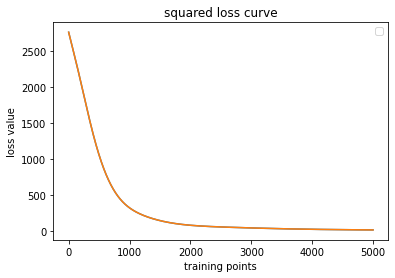

In [89]:
pd.DataFrame(model_nn.loss_curve_).plot()
plt.plot(model_nn.loss_curve_)
plt.title('squared loss curve')
plt.ylabel('loss value')
plt.xlabel('training points')
plt.legend([])
plt.show()

## xgboost 

In [1050]:
param_grid = {
        'silent': [False],
        'max_depth': [6, 10, 15, 20],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'reg_alpha': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
#        'gamma': [0, 0.25, 0.5, 1.0],
#        'n_estimators': [100]
}

In [1051]:
clf = xgb.XGBClassifier()
#cv=3 uso la misma que en xgb.cv mas arriba
rs_clf = RandomizedSearchCV(clf, param_grid,      
                      verbose=2, cv=3,  
                      scoring='neg_mean_squared_error', 
                     )

In [1054]:
#'log_pages_per_day_samples', corresponde a np.log(df.'pages_per_day_samples')
#'log_pages_per_day_samples_x_age_samples' corresponde a log_pages_per_day_samples * age_samples
X = df[['pages_per_day_samples',
        'age_samples',
        #'log_pages_per_day_samples',
        #'log_pages_per_day_samples_x_age_samples'
       ]]
y = df.days_in_yrs_samples

print("Randomized search..")
search_time_start = time.time()
#le paso X, y en vez de el x_train, y_train ( que es un % del total ) porque estoy usando cross validation, 
#si no usara CV deberia tener cuidado y validar si le paso x_train, y_train , xq se podria dar el caso de que 
# como hace el entrenamiento con la totalidad de los datos, luego el x_test, y_test van a dar muy bien y no es el caso.
rs_clf.fit(X, y)
print("Randomized search time:", time.time() - search_time_start)

Randomized search..
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] silent=False, reg_alpha=10.0, max_depth=20, learning_rate=3, colsample_bytree=0.8 
[CV]  silent=False, reg_alpha=10.0, max_depth=20, learning_rate=3, colsample_bytree=0.8, total=   0.1s
[CV] silent=False, reg_alpha=10.0, max_depth=20, learning_rate=3, colsample_bytree=0.8 


//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  silent=False, reg_alpha=10.0, max_depth=20, learning_rate=3, colsample_bytree=0.8, total=   0.1s
[CV] silent=False, reg_alpha=10.0, max_depth=20, learning_rate=3, colsample_bytree=0.8 
[CV]  silent=False, reg_alpha=10.0, max_depth=20, learning_rate=3, colsample_bytree=0.8, total=   0.1s
[CV] silent=False, reg_alpha=1.0, max_depth=20, learning_rate=0.2, colsample_bytree=1.0 
[CV]  silent=False, reg_alpha=1.0, max_depth=20, learning_rate=0.2, colsample_bytree=1.0, total=   0.1s
[CV] silent=False, reg_alpha=1.0, max_depth=20, learning_rate=0.2, colsample_bytree=1.0 
[CV]  silent=False, reg_alpha=1.0, max_depth=20, learning_rate=0.2, colsample_bytree=1.0, total=   0.1s
[CV] silent=False, reg_alpha=1.0, max_depth=20, learning_rate=0.2, colsample_bytree=1.0 
[CV]  silent=False, reg_alpha=1.0, max_depth=20, learning_rate=0.2, colsample_bytree=1.0, total=   0.1s
[CV] silent=False, reg_alpha=5.0, max_depth=20, learning_rate=0, colsample_bytree=0.4 
[CV]  silent=False, reg_alpha=5.0, max_d

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    3.3s finished


In [1058]:
best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))
    
print("\n- The metrics obtained with XGBoost are much worse than those obtained with the linear reg or the NN")

Best score: -233.80476190476188
Best params: 
colsample_bytree: 1.0
learning_rate: 0.2
max_depth: 20
reg_alpha: 1.0
silent: False

- Las metricas obtenidas con XGBoost son mucho peores que las obtenidas con la reg lineal o la NN


### XGBoost analysis won't continue , we will focus on the linear model and / or NN